In [958]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import random
from geopy.geocoders import Nominatim
import io
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import folium

# Verzamelen van Toegangstoken
In dit blok halen we een toegangstoken op voor de verbinding met de Sentinel Hub API. Dit token wordt later gebruikt om gegevens op te vragen.

In [959]:
CLIENT_ID = "cbd517e2-9cc3-45eb-9676-b7d819396197"
CLIENT_SECRET = "cE9yVPSLYDCON304gWDfZeDjLYE9SlpL"

# Set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# Verkrijg het toegangstoken
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
                          client_secret=CLIENT_SECRET, include_client_id=True)


# Genereren van een Willekeurige Bounding Box en Locatie
Genereren van willekeurige bounding box binnen gespecificeerde geografische grenzen en haalt de bijbehorende locatie-naam op.

In [960]:
# Functie om een willekeurige bounding box binnen een bepaald gebied te genereren
def generate_random_bbox(lat_min, lat_max, lon_min, lon_max, max_size_deg=1.0):
    lat1 = random.uniform(lat_min, lat_max)
    lon1 = random.uniform(lon_min, lon_max)

    # Beperk de grootte van de bounding box
    lat2 = lat1 + random.uniform(-max_size_deg, max_size_deg)
    lon2 = lon1 + random.uniform(-max_size_deg, max_size_deg)
    
    bbox = [min(lon1, lon2), min(lat1, lat2), max(lon1, lon2), max(lat1, lat2)]
    return bbox

# Functie om de locatie-naam te verkrijgen via Geopy (Nominatim)
def get_location_name(lat, lon):
    geolocator = Nominatim(user_agent="random_bbox_app")
    location = geolocator.reverse((lat, lon), language='en')
    return location.address if location else "Onbekende locatie"

# Specificeer de grenzen voor willekeurige coördinaten (bijvoorbeeld voor Europa)
lat_min = -60.0  # Minimum breedtegraad
lat_max = 90.0  # Maximum breedtegraad
lon_min = -180.0  # Minimum lengtegraad
lon_max = 180.0  # Maximum lengtegraad

# Genereer een willekeurige bounding box
bbox_random = generate_random_bbox(lat_min, lat_max, lon_min, lon_max)
print(f"Willekeurige Bounding Box: {bbox_random}")

# Verkrijg de locatie-naam voor het middelpunt van de bounding box
center_lat = (bbox_random[1] + bbox_random[3]) / 2
center_lon = (bbox_random[0] + bbox_random[2]) / 2
location_name = get_location_name(center_lat, center_lon)

print(f"Locatie van het centrum van de bounding box: {location_name}")

# Print de coördinaten van het middelpunt
print(f"Centrum coördinaten: Breedtegraad {center_lat}, Lengtegraad {center_lon}")

Willekeurige Bounding Box: [-51.76056600022695, -7.388038171044826, -50.791286883895566, -6.522111661187882]
Locatie van het centrum van de bounding box: Tucumã, Região Geográfica Imediata de Tucumã - São Félix do Xingu, Região Geográfica Intermediária de Redenção, Pará, North Region, 68385-000, Brazil
Centrum coördinaten: Breedtegraad -6.955074916116354, Lengtegraad -51.27592644206126


# Verzoek naar Sentinel Hub API voor Satellietdata
Een verzoek maken naar de Sentinel Hub API om satellietafbeeldingen te verkrijgen voor een willekeurige bounding box. Het haalt de data op in de vorm van een composietafbeelding met de banden voor rood, groen, blauw en nabij-infrarood.

In [961]:
# Stel de parameters in voor het gebied (bbox), begin- en einddatum
bbox = bbox_random  # Geef random bbox waarde door als variabele
start_date = "2023-06-01"
end_date = "2023-09-01"
collection_id = "sentinel-2-l2a"

# Het evalscript voor het berekenen van een true-color composiet (R: B4, G: B3, B: B2)
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02", "B08"],  // Voeg B8 (NIR) toe
    output: {
      bands: 4,
      sampleType: "AUTO"
    }
  }
}

function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02, sample.B08]; // Retourneer de juiste banden
}
"""

# Stel de URL voor de API-aanroep in
url_request = "https://services.sentinel-hub.com/api/v1/process"

# Headers voor de API-aanroep, inclusief de autorisatie-header met het toegangstoken
headers_request = {
    "Authorization": f"Bearer {token['access_token']}"  # Zorg ervoor dat je toegangstoken correct is ingesteld
}

# Vraag voor een composietbeeld met de juiste banden aan via de API
json_request = {
    'input': {
        'bounds': {
            'bbox': bbox,
            'properties': {
                'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
            }
        },
        'data': [
            {
                'type': collection_id,
                'dataFilter': {
                    'timeRange': {
                        'from': f'{start_date}T00:00:00Z',
                        'to': f'{end_date}T23:59:59Z'
                    },
                    'mosaickingOrder': 'leastCC',
                },
            }
        ]
    },
    'output': {
        'width': 1024,
        'height': 1024,
        'responses': [
            {
                'identifier': 'default',
                'format': {
                    'type': 'image/tiff',
                }
            }
        ]
    },
    'evalscript': evalscript
}

# Verstuur het verzoek naar de API
response = oauth.request("POST", url_request, headers=headers_request, json=json_request)

# Controleer de status van de API-respons
if response.status_code == 200:
    print("API request was succesvol!")
    img_data = response.content
else:
    print(f"Fout bij API-aanroep: {response.status_code}")
    print(response.text)  # Bekijk de foutmelding van de API

API request was succesvol!


# Verwerken en Visualiseren van Satellietdata
De ontvangen satellietdata openen, de banden van de afbeelding geëxtraheerd en de NDVI (Normalized Difference Vegetation Index) berekend. Vervolgens worden de originele afbeelding en de NDVI-uitvoer gevisualiseerd.

Vorm van de rode band: (1024, 1024)
Vorm van de groene band: (1024, 1024)
Vorm van de blauwe band: (1024, 1024)
Vorm van de NIR band: (1024, 1024)


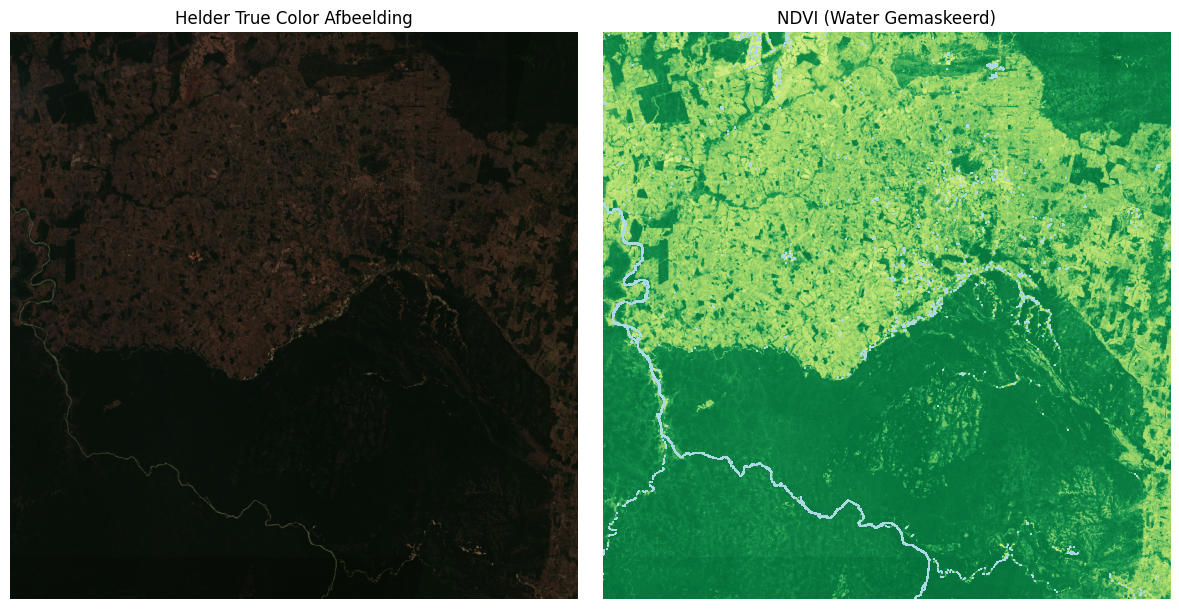

NDVI Min: -1.0, NDVI Max: 1.0


In [962]:
# Open het TIFF-bestand met rasterio
with rasterio.open(io.BytesIO(img_data)) as src:
    # Haal de banden B4 (rood), B3 (groen), B2 (blauw), en B8 (NIR) uit het TIFF-bestand
    red_band = src.read(1)  # B4
    green_band = src.read(2)  # B3
    blue_band = src.read(3)  # B2
    nir_band = src.read(4)  # B8

    # Optioneel: Controleer de vormen van de banden
    print("Vorm van de rode band:", red_band.shape)
    print("Vorm van de groene band:", green_band.shape)
    print("Vorm van de blauwe band:", blue_band.shape)
    print("Vorm van de NIR band:", nir_band.shape)

# Normaliseer de RGB- en NIR-banden naar een bereik van [0, 1]
red_band_normalized = red_band / 255.0
green_band_normalized = green_band / 255.0
blue_band_normalized = blue_band / 255.0
nir_band_normalized = nir_band / 255.0  # Normaliseer de NIR-band

# Bereken de NDVI met veilige berekening
def calculate_ndvi_safe(nir, red):
    # Vermijd deling door nul door eerst te controleren
    denominator = nir + red
    denominator = denominator.astype(float)  # Zet om naar float
    denominator[denominator == 0] = np.nan  # Zet nulwaarden om in NaN
    return (nir - red) / denominator

# Bereken de NDVI
ndvi = calculate_ndvi_safe(nir_band_normalized, red_band_normalized)

# Vervang NaN en inf waarden door een geldige waarde (bijv. -1 of 0)
ndvi = np.nan_to_num(ndvi, nan=-1, posinf=-1, neginf=-1)

# Masker water (NDVI < 0) en stel die gebieden in op een neutrale waarde (bijvoorbeeld -1)
ndvi[ndvi < 0] = -1  # Water maskeren

# Normaliseer NDVI naar het bereik [-1, 1] (optioneel, want NDVI is al in dit bereik)
ndvi_rescaled = np.interp(ndvi, (ndvi.min(), ndvi.max()), (-1, 1))

# Pas helderheid aan voor de true-color afbeelding
# Normaliseer RGB-banden opnieuw voor betere visualisatie
def enhance_brightness(band, scale_factor=1.5):
    band = band * scale_factor
    band[band > 1] = 1  # Beperk waarden tot maximaal 1
    return band

red_band_enhanced = enhance_brightness(red_band_normalized)
green_band_enhanced = enhance_brightness(green_band_normalized)
blue_band_enhanced = enhance_brightness(blue_band_normalized)

true_color_image_enhanced = np.dstack((red_band_enhanced, green_band_enhanced, blue_band_enhanced))

# Visualiseer de heldere true-color afbeelding en de NDVI-uitvoer met water gemaskeerd
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Toon de verbeterde true-color afbeelding
axes[0].imshow(true_color_image_enhanced)
axes[0].set_title('Helder True Color Afbeelding')
axes[0].axis('off')  # Zet de assen uit voor esthetiek

# Toon de NDVI-uitvoer met water gemaskeerd
masked_ndvi = np.ma.masked_where(ndvi == -1, ndvi_rescaled)  # Masker watergebieden
cmap = plt.cm.RdYlGn  # Kleurenschema voor NDVI
cmap.set_bad(color='lightblue')  # Stel gemaskeerde (water) gebieden in op lichtblauw
axes[1].imshow(masked_ndvi, cmap=cmap, vmin=-1, vmax=1)
axes[1].set_title('NDVI (Water Gemaskeerd)')
axes[1].axis('off')  # Zet de assen uit voor esthetiek

# Toon beide afbeeldingen
plt.tight_layout()
plt.show()

# Print opnieuw minimale en maximale NDVI-waarden
print(f"NDVI Min: {ndvi_rescaled.min()}, NDVI Max: {ndvi_rescaled.max()}")


# Segmenteren van gebieden

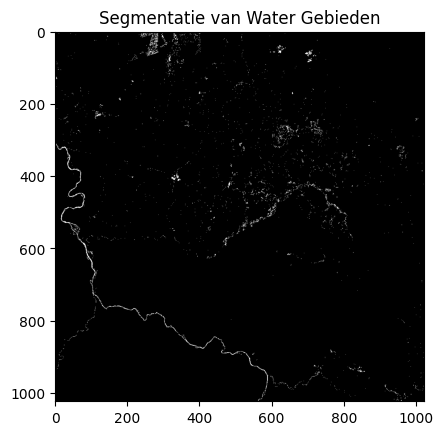

In [963]:
# Segmentatie van gebieden met NDVI < 0.2
threshold = 0.2
segmented = (ndvi_rescaled < threshold).astype(np.uint8)  # Zet de afbeelding om naar 8-bit

# Visualiseer de segmentatie
plt.imshow(segmented, cmap='gray')
plt.title('Segmentatie van Water Gebieden')
plt.show()

# Machine Learning Model voor NDVI Voorspelling
Random Forest-regressor gebruiken om de NDVI te voorspellen op basis van de bestaande kenmerken van de afbeelding.

In [964]:
mask_water = (ndvi_rescaled == -1)  # Watergebieden
ndvi_non_water = ndvi_rescaled[~mask_water]  # Alleen niet-watergebieden
X_non_water = np.stack([red_band[~mask_water], nir_band[~mask_water]], axis=-1)  # Training zonder water

In [965]:
# Clustering gebruiken om NDVI-waarden te categoriseren.

# K-Means clustering uitvoeren
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_non_water)

# Toewijzing van clusters aan de gehele rasterafbeelding
predicted_clusters = np.full(ndvi_rescaled.shape, -1)  # Begin met alles op -1 (water)
predicted_clusters[~mask_water] = kmeans.predict(X_non_water)  # Voorspelling op niet-water pixels

# Map clusterlabels naar classificaties
cluster_labels = {
    2: "Slecht",
    1: "Matig",
    0: "Goed",
}
classified_ndvi = np.full(ndvi_rescaled.shape, "Onbekend", dtype=object)
for cluster, label in cluster_labels.items():
    classified_ndvi[predicted_clusters == cluster] = label

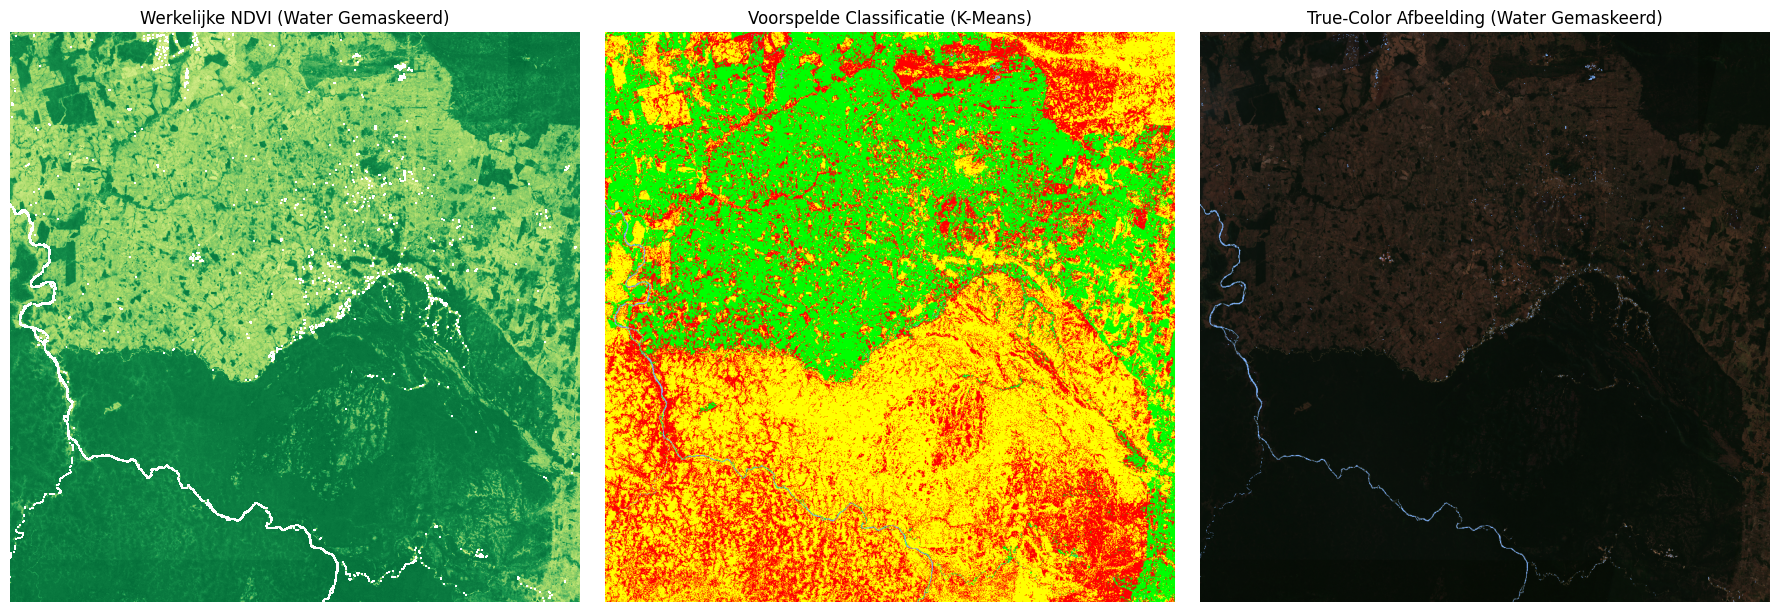

In [966]:
# Masker RGB-banden voor water
true_color_image_masked = np.copy(true_color_image_enhanced)
true_color_image_masked[mask_water] = [0.5, 0.7, 1.0]  # Lichtblauw voor water

# Toon werkelijke NDVI en voorspellingen
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Werkelijke NDVI
axes[0].imshow(np.ma.masked_where(mask_water, ndvi_rescaled), cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title('Werkelijke NDVI (Water Gemaskeerd)')
axes[0].axis('off')

# Voorspelde classificatie met de juiste kleurmap
color_map = {"Goed": (0, 1, 0), "Matig": (1, 1, 0), "Slecht": (1, 0, 0)}  # Goed = Green, Matig = Yellow, Slecht = Red
classified_image = np.zeros((*classified_ndvi.shape, 3))
for label, color in color_map.items():
    classified_image[classified_ndvi == label] = color
classified_image[mask_water] = [0.5, 0.7, 1.0]  # Lichtblauw voor water
axes[1].imshow(classified_image)
axes[1].set_title('Voorspelde Classificatie (K-Means)')
axes[1].axis('off')

# True-color afbeelding
axes[2].imshow(true_color_image_masked)
axes[2].set_title('True-Color Afbeelding (Water Gemaskeerd)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [967]:
# Genereer de Google Maps link in decimale graden
google_maps_link = f"https://www.google.com/maps?q={center_lat},{center_lon}"

# Print de link
print(f"Bekijk de locatie op Google Maps: {google_maps_link}")


Bekijk de locatie op Google Maps: https://www.google.com/maps?q=-6.955074916116354,-51.27592644206126


In [968]:
def generate_kmeans_conclusion(clusters, cluster_labels):
    """
    Bepaalt een conclusie gebaseerd op de clustering-output.
    
    Parameters:
    - clusters: De clusterlabels per pixel (zoals 0, 1, 2 voor KMeans).
    - cluster_labels: De bijbehorende labels (zoals "Goed", "Matig", "Slecht") voor de clusters.
    
    Returns:
    - Een geformatteerde string met de conclusies.
    """
    unique, counts = np.unique(clusters, return_counts=True)
    total_pixels = np.sum(counts)
    
    # De percentages worden nu correct berekend met behulp van de clusterindices
    percentages = {cluster_labels[cluster]: (count / total_pixels) * 100 for cluster, count in zip(unique, counts)}

    # Opstellen conclusie op basis van percentages
    conclusion = "Conclusie over de voorspelde toestand:\n"
    if percentages.get("Goed", 0) > 70:
        conclusion += "Het grootste deel van het gebied verkeert in een goede toestand.\n"
    elif percentages.get("Matig", 0) > 50:
        conclusion += "Een aanzienlijk deel van het gebied verkeert in een matige toestand.\n"
    elif percentages.get("Slecht", 0) > 30:
        conclusion += "Een zorgwekkend groot deel van het gebied verkeert in een slechte toestand.\n"
    else:
        conclusion += "Het gebied toont een gemengde toestand zonder duidelijke dominantie.\n"

    # Gedetailleerd overzicht
    conclusion += "\nDetails per toestand:\n"
    for label, percentage in percentages.items():
        conclusion += f"- {label}: {percentage:.2f}% van het gebied.\n"

    return conclusion

# Stel je clusterlabels en labels (zoals "Goed", "Matig", "Slecht") in
cluster_labels = predicted_clusters  # Dit zijn de voorspelde clusterlabels
cluster_labels_text = ["Goed", "Matig", "Slecht"]  # De bijbehorende labels voor de clusters

# Toon conclusie gebaseerd op de voorspelde clusters
kmeans_conclusion = generate_kmeans_conclusion(cluster_labels, cluster_labels_text)
print(kmeans_conclusion)

Conclusie over de voorspelde toestand:
Het gebied toont een gemengde toestand zonder duidelijke dominantie.

Details per toestand:
- Slecht: 27.88% van het gebied.
- Goed: 31.10% van het gebied.
- Matig: 40.68% van het gebied.

